In [1]:
import matplotlib
matplotlib.use('agg')

import xarray as xr
import pyart
pyart.config.get_field_colormap('CZ')
pycm = matplotlib.cm.get_cmap(pyart.config.get_field_colormap('CZ'))

import sys
import os
sys.path.insert(0, os.path.abspath('/home/bdolan/python/'))


import h5py
import numpy as np
import matplotlib.pyplot as plt

try:
    plt.style.use('presentation')
except Exception:
    pass

import glob
import numpy as np
import imp
import sys
#import bottleneck as bn
import oa_stats as oa
import analysis_tools as AT

import Config

import pickle as pickle

import scipy.stats as stats
import scipy
import pandas
import dsd_helper_functions as dfunc
from matplotlib import colors
import matplotlib as mpl
import os
import argparse
import time
from matplotlib.colors import LogNorm



plt.rcParams.update({'font.size': 18})


%load_ext autoreload
%autoreload 2




#sys.setdefaultencoding('utf8')
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
fig_dir = '/precipitation/bdolan/JGR_FIGS/RV1/'

In [3]:
cfg = Config.Config('/precipitation/bdolan/BASELINE/simulation_settings_vsense.yaml')
ycfg = cfg.v



In [4]:
cols=['gray','r','g','gold','blue','orange','purple']

pcacol = colors.ListedColormap(cols)
def adjust_fhc_colorbar_for_pyart(cb):
    cb.set_ticks(np.arange(0.4, 7.4, 1.0))
    cb.ax.set_yticklabels(['Amb','Conv', 'Strat', 'Shall', 'Aggreg',
                           'C-C', 'Ice'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb




In [5]:
def get_rams_datagroups(exper,rthresh=0.9,muval=0.0,mu=0.0):
    alldsd = pickle.load(open('/precipitation/bdolan/ramsworld3_dsd_mass.p','rb')) 
    rfile =ycfg['sims'][exper]['rain_file']
    dfile =ycfg['sims'][exper]['diam_file']
    ddir = ycfg['sims'][exper]['dirnam']
    print(dfile)
    sim_cfg = ycfg['sims'][exper]
    nu = sim_cfg['nu']
    if nu != 'bin':
        nu = int(nu)
        mu = nu-1
    else:
        mu = mu
    tskip = sim_cfg['tskip']
    hskip = sim_cfg['hskip']
    print(f"working on {exper}",rfile)
    data = xr.open_dataset(f'/precipitation/smsaleeb/NOBAK/DOE.MICRO-simulations/{ddir}/{rfile}')#,engine='h5netcdf')
    print(f'/precipitation/smsaleeb/NOBAK/DOE.MICRO-simulations/{ddir}/{dfile}')
    diam = xr.open_dataset(f'/precipitation/smsaleeb/NOBAK/DOE.MICRO-simulations/{ddir}/{dfile}')
    tms = []
    tt=0
    for t,r in enumerate(data['t_coords'][::tskip].values):
        tt=tt+tskip
        tms.append(tt)

    
    if muval == 0.0:
        filtered_rain_dsd_dict = dfunc.format_subsample_dsd_data_diam(data,diam, nu=mu, tskip=tskip, hskip=hskip,d3=False)
        
    else:
        filtered_rain_dsd_dict = dfunc.format_subsample_dsd_data_diam(data,diam, nu=mu,mu=muval, tskip=tskip, hskip=hskip,d3=False)

    blank = np.zeros((filtered_rain_dsd_dict['shp'][0],filtered_rain_dsd_dict['shp'][1],filtered_rain_dsd_dict['shp'][2]))

    ramr =np.ravel(np.zeros_like(blank))
    ramr[filtered_rain_dsd_dict['whgd']]=filtered_rain_dsd_dict['rrr']
    ramrr = np.reshape(ramr,filtered_rain_dsd_dict['shp'])

    ramn =np.ravel(np.zeros_like(blank))
    ramn[filtered_rain_dsd_dict['whgd']]=filtered_rain_dsd_dict['nww']
    ramnw = np.reshape(ramn,filtered_rain_dsd_dict['shp'])

    ramd =np.ravel(np.zeros_like(blank))
    ramd[filtered_rain_dsd_dict['whgd']]=filtered_rain_dsd_dict['d00']
    ramd0 = np.reshape(ramd,filtered_rain_dsd_dict['shp'])

    blankr=np.ravel(blank)
    blankb = blankr[filtered_rain_dsd_dict['whgd']]
    
    good_vars = ['nww', 'dmm', 'sigm', 'llwc', 'lrr', 'lnt']

    labels = [ycfg['vars'][_]['label'] for _ in good_vars]
    pc1sea, pc2sea = oa.get_eof_cast(filtered_rain_dsd_dict,alldsd,good_vars)

    ramsgroups1 = dfunc.get_groups(pc1sea,pc2sea,rthresh,rthresh,rthresh,rthresh)
    ramsvals1 = dfunc.make_groups(pc1sea,ramsgroups1)


    ramvals2dr =np.ravel(np.zeros_like(blank))*np.nan
    ramvals2dr[filtered_rain_dsd_dict['whgd']]=ramsvals1
    ramvals2d = np.reshape(ramvals2dr,filtered_rain_dsd_dict['shp'])
    


    return data, tms, ramvals2d, pc1sea,pc2sea,filtered_rain_dsd_dict,ramsgroups1


In [6]:
# exper = 'supercell_nu2'
# rfile =ycfg['sims'][exper]['rain_file']
# dfile =ycfg['sims'][exper]['diam_file']
# ddir = ycfg['sims'][exper]['dirnam']

# data = xr.open_dataset(f'/precipitation/smsaleeb/NOBAK/DOE.MICRO-simulations/{ddir}/{rfile}')#,engine='h5netcdf')
# diam = xr.open_dataset(f'/precipitation/smsaleeb/NOBAK/DOE.MICRO-simulations/{ddir}/{dfile}')


In [7]:
#int((f'/precipitation/smsaleeb/NOBAK/DOE.MICRO-simulations/{ddir}/{dfile}'))

In [8]:
dfunc.__file__

'/home/bdolan/python/dsd_helper_functions.py'

In [9]:
supnu2, nu2tms, n2rams2d, n2pc1,n2pc2, n2filtered_rain_dsd_dict,n2groups = get_rams_datagroups('supercell_nu2')

supercell-grant-hires-gnu02-g1-diam.h5
working on supercell_nu2 supercell-grant-hires-gnu02-g1-rain.h5
/precipitation/smsaleeb/NOBAK/DOE.MICRO-simulations/h5e.supercell.grant.hires.gnu02.300dx/supercell-grant-hires-gnu02-g1-diam.h5
npshape d0d (19, 250, 317)
d3 is  False
rr shape (19, 250, 317)
(19, 250, 317)
0.0


In [10]:
supnu1, nu1tms, n1rams2d, n1pc1,n1pc2, n1filtered_rain_dsd_dict,n1groups = get_rams_datagroups('supercell_nu1')

supercell-grant-hires-gnu01-g1-diam.h5
working on supercell_nu1 supercell-grant-hires-gnu01-g1-rain.h5
/precipitation/smsaleeb/NOBAK/DOE.MICRO-simulations/h5e.supercell.grant.hires.gnu01.300dx/supercell-grant-hires-gnu01-g1-diam.h5
npshape d0d (19, 250, 317)
d3 is  False
rr shape (19, 250, 317)
(19, 250, 317)
0.0


In [11]:
supnu3, nu3tms, n3rams2d, n3pc1,n3pc2,n3filtered_rain_dsd_dict, n3groups = get_rams_datagroups('supercell_nu3')

supercell-grant-hires-gnu03-g1-diam.h5
working on supercell_nu3 supercell-grant-hires-gnu03-g1-rain.h5
/precipitation/smsaleeb/NOBAK/DOE.MICRO-simulations/h5e.supercell.grant.hires.gnu03.300dx/supercell-grant-hires-gnu03-g1-diam.h5
npshape d0d (19, 250, 317)
d3 is  False
rr shape (19, 250, 317)
(19, 250, 317)
0.0


In [12]:
supnu4, nu4tms, n4rams2d, n4pc1,n4pc2,n4filtered_rain_dsd_dict,n4groups = get_rams_datagroups('supercell_nu4')

supercell-grant-hires-gnu04-g1-diam.h5
working on supercell_nu4 supercell-grant-hires-gnu04-g1-rain.h5
/precipitation/smsaleeb/NOBAK/DOE.MICRO-simulations/h5e.supercell.grant.hires.gnu04.300dx/supercell-grant-hires-gnu04-g1-diam.h5
npshape d0d (19, 250, 317)
d3 is  False
rr shape (19, 250, 317)
(19, 250, 317)
0.0


In [13]:
supnu10, nu10tms, n10rams2d, n10pc1,n10pc2,n10filtered_rain_dsd_dict,n10groups = get_rams_datagroups('supercell_nu10')

supercell-grant-hires-gnu10-g1-diam.h5
working on supercell_nu10 supercell-grant-hires-gnu10-g1-rain.h5
/precipitation/smsaleeb/NOBAK/DOE.MICRO-simulations/h5e.supercell.grant.hires.gnu10.300dx/supercell-grant-hires-gnu10-g1-diam.h5
npshape d0d (19, 250, 317)
d3 is  False
rr shape (19, 250, 317)
(19, 250, 317)
0.0


In [17]:
import sys
import os
sys.path.insert(0, os.path.abspath('/home/bdolan/python/DOE/'))


from PyDSD import pydsd


dsd = np.load('/home/bdolan/python/DOE/my_mu_supercell_skip_dsd.p.npy',allow_pickle=True)

In [18]:
#dsd.fields.keys()

In [19]:
# shp = dsd.shp
# mu = np.reshape(dsd.fields['mu']['data'],(shp[0],shp[1], shp[2]))

In [20]:
supnuH, nuHtms, nHrams2d, nHpc1,nHpc2,nHfiltered_rain_dsd_dict,nHgroups = get_rams_datagroups('supercell_bin')

supercell-grant-hires-hucm-g1-diam.h5
working on supercell_bin supercell-grant-hires-hucm-g1-rain.h5
/precipitation/smsaleeb/NOBAK/DOE.MICRO-simulations/h5e.supercell.grant.hires.hucm.300dx/supercell-grant-hires-hucm-g1-diam.h5
npshape d0d (19, 250, 317)
d3 is  False
rr shape (19, 250, 317)
(19, 250, 317)
0.0


In [21]:
hist1, eg = np.histogram(np.ravel(n1rams2d),bins=np.arange(0,8,1))
hist2, eg = np.histogram(np.ravel(n2rams2d),bins=np.arange(0,8,1))
hist3, eg = np.histogram(np.ravel(n3rams2d),bins=np.arange(0,8,1))

hist4, eg = np.histogram(np.ravel(n4rams2d),bins=np.arange(0,8,1))

hist10, eg = np.histogram(np.ravel(n10rams2d),bins=np.arange(0,8,1))


histH, eg = np.histogram(np.ravel(nHrams2d),bins=np.arange(0,8,1))




In [22]:
np.shape(n1rams2d)
print(nu2tms)

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38]


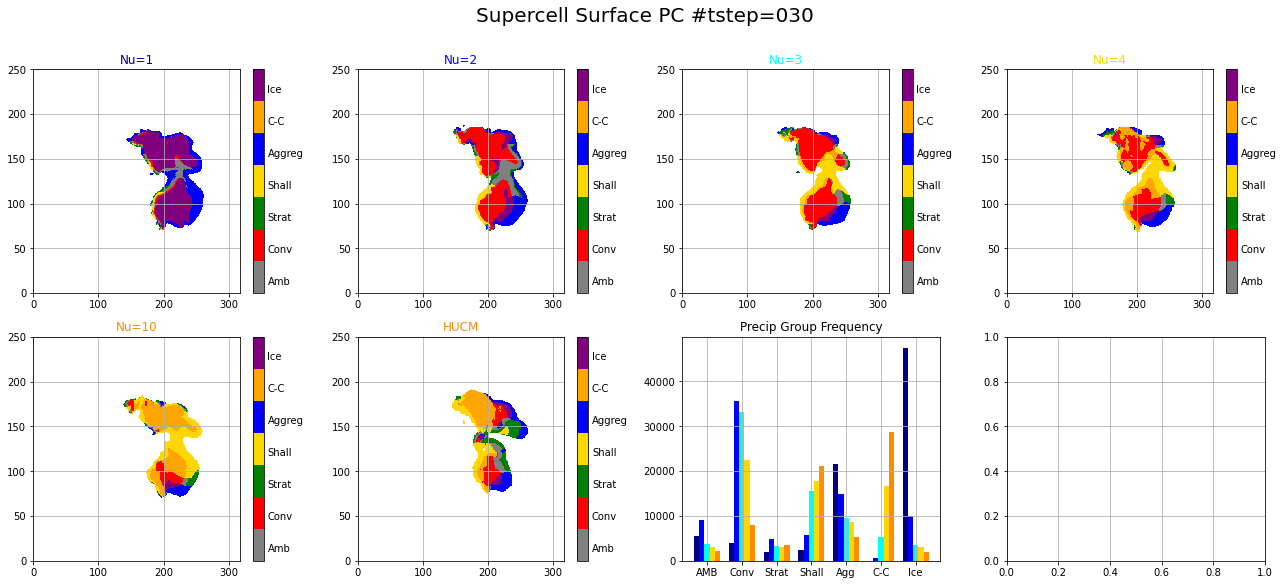

In [23]:
fig, ax = plt.subplots(2,4,figsize=(18,8))
axf = ax.flatten()

tms = 14
f=0
c = axf[f].pcolormesh(n1rams2d[tms,:,:],vmin=0,vmax=7,cmap=pcacol)
cb = plt.colorbar(c,ax=axf[f])
adjust_fhc_colorbar_for_pyart(cb)
axf[f].set_title("Nu=1",color='navy')


f=1
c = axf[f].pcolormesh(n2rams2d[tms,:,:],vmin=0,vmax=7,cmap=pcacol)
cb = plt.colorbar(c,ax=axf[f])
adjust_fhc_colorbar_for_pyart(cb)
axf[f].set_title("Nu=2",color='blue')



f=2
c = axf[f].pcolormesh(n3rams2d[tms,:,:],vmin=0,vmax=7,cmap=pcacol)
cb = plt.colorbar(c,ax=axf[f])
adjust_fhc_colorbar_for_pyart(cb)
axf[f].set_title("Nu=3",color='cyan')


f=3
c = axf[f].pcolormesh(n4rams2d[tms,:,:],vmin=0,vmax=7,cmap=pcacol)
cb = plt.colorbar(c,ax=axf[f])
adjust_fhc_colorbar_for_pyart(cb)
axf[f].set_title("Nu=4",color='gold')


f=4
c = axf[f].pcolormesh(n10rams2d[tms,:,:],vmin=0,vmax=7,cmap=pcacol)
cb = plt.colorbar(c,ax=axf[f])
adjust_fhc_colorbar_for_pyart(cb)
axf[f].set_title("Nu=10",color='darkorange')

f=5
c = axf[f].pcolormesh(nHrams2d[tms,:,:],vmin=0,vmax=7,cmap=pcacol)
cb = plt.colorbar(c,ax=axf[f])
adjust_fhc_colorbar_for_pyart(cb)
axf[f].set_title("HUCM",color='darkorange')


f=6
axf[f].bar(eg[:-1],hist1,width=0.15,color='navy')
axf[f].bar(eg[:-1]+0.15,hist2,width=0.15,color='blue')
axf[f].bar(eg[:-1]+0.3,hist3,width=0.15,color='cyan')
axf[f].bar(eg[:-1]+0.45,hist4,width=0.15,color='gold')
axf[f].bar(eg[:-1]+0.6,hist10,width=0.15,color='darkorange')

axf[f].set_title('Precip Group Frequency')
axf[f].set_xticks(np.arange(0.3,7,1))
axf[f].set_xticklabels(['AMB','Conv','Strat','Shall','Agg','C-C','Ice'])

for a in axf:
    a.grid()
plt.suptitle(f"Supercell Surface PC #tstep={nu10tms[tms]:03d}",fontsize=20,y=1.01)
plt.tight_layout()
plt.savefig(f'{fig_dir}Supercell_Nutest_{nu10tms[tms]:03d}_sfc.png',dpi=300,bbox_inches='tight')



In [24]:
obsraindata = pickle.load(open("/precipitation/bdolan/RAMS/pickles/worldraindata_NEW_nohi.p",'rb'),encoding='latin1')


obsdata = pickle.load(open("/precipitation/bdolan/RAMS/pickles/world_dsd_NEW_nohi.p",'rb'),encoding='latin1')

opc1 = obsdata.get_pc(rank=1)
opc2 = obsdata.get_pc(rank=2)




orr = obsdata.data['rrr']
od0 = obsdata.data['d00']
onw = obsdata.data['nww']
odt = obsdata.data['datetime']
o3groups = dfunc.get_groups(opc1,opc2,1.0,1.0,1.0,1.0)

In [25]:
whmc3e = np.where(obsdata.data['exper']=='sgp')

In [26]:

o3groupssgp = dfunc.get_groups(opc1[whmc3e],opc2[whmc3e],1.0,1.0,1.0,1.0)

<>:18: DeprecationWarning: invalid escape sequence \m
<>:24: DeprecationWarning: invalid escape sequence \m
<>:28: DeprecationWarning: invalid escape sequence \m
<>:32: DeprecationWarning: invalid escape sequence \m
<>:36: DeprecationWarning: invalid escape sequence \m
<>:18: DeprecationWarning: invalid escape sequence \m
<>:24: DeprecationWarning: invalid escape sequence \m
<>:28: DeprecationWarning: invalid escape sequence \m
<>:32: DeprecationWarning: invalid escape sequence \m
<>:36: DeprecationWarning: invalid escape sequence \m
/tmp/ipykernel_44058/3878762299.py:18: DeprecationWarning: invalid escape sequence \m
  axf[0].set_title("$\mu$0",fontsize=14)
/tmp/ipykernel_44058/3878762299.py:24: DeprecationWarning: invalid escape sequence \m
  axf[1].set_title('$\mu$1',fontsize=14)
/tmp/ipykernel_44058/3878762299.py:28: DeprecationWarning: invalid escape sequence \m
  axf[2].set_title('$\mu$2',fontsize=14)
/tmp/ipykernel_44058/3878762299.py:32: DeprecationWarning: invalid escape seque

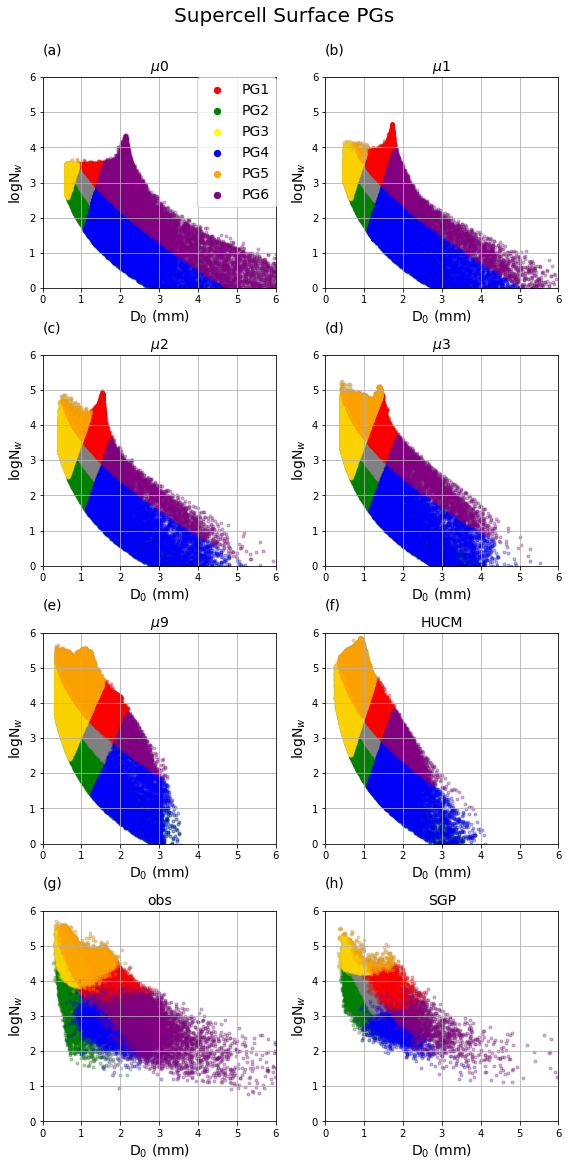

In [27]:
fig, ax = plt.subplots(4,2,figsize=(8,16))
axf = ax.flatten()

#tms = 10
f=0
i=0
axf[i].scatter(-1,-1,color='r',s=40,label='PG1')
axf[i].scatter(-1,-1,color='g',s=40,label='PG2')
axf[i].scatter(-1,-1,color='yellow',s=40,label='PG3')
axf[i].scatter(-1,-1,color='blue',s=40,label='PG4')
axf[i].scatter(-1,-1,color='orange',s=40,label='PG5')
axf[i].scatter(-1,-1,color='purple',s=40,label='PG6')
axf[i].legend(loc=0,
     borderaxespad=0.,fontsize=14,scatterpoints=1,markerscale=1)#,mode='expand')#ld.set_title('Groups')

axf[0] = dfunc.plot_groups(n1filtered_rain_dsd_dict['d00'],(n1filtered_rain_dsd_dict['nww']),n1groups,axf[0])#,line_on=1)#f[0])
handles, labels = axf[0].get_legend_handles_labels()
axf[0].set_title("$\mu$0",fontsize=14)



axf[1] = dfunc.plot_groups(n2filtered_rain_dsd_dict['d00'],(n2filtered_rain_dsd_dict['nww']),n2groups,axf[1])#,line_on=1)#f[0])
handles, labels = axf[1].get_legend_handles_labels()
axf[1].set_title('$\mu$1',fontsize=14)

axf[2] = dfunc.plot_groups(n3filtered_rain_dsd_dict['d00'],(n3filtered_rain_dsd_dict['nww']),n3groups,axf[2])#,line_on=1)#f[0])
handles, labels = axf[2].get_legend_handles_labels()
axf[2].set_title('$\mu$2',fontsize=14)

axf[3] = dfunc.plot_groups(n4filtered_rain_dsd_dict['d00'],(n4filtered_rain_dsd_dict['nww']),n4groups,axf[3])#,line_on=1)#f[0])
handles, labels = axf[3].get_legend_handles_labels()
axf[3].set_title('$\mu$3',fontsize=14)

axf[4] = dfunc.plot_groups(n10filtered_rain_dsd_dict['d00'],(n10filtered_rain_dsd_dict['nww']),n10groups,axf[4])#,line_on=1)#f[0])
handles, labels = axf[4].get_legend_handles_labels()
axf[4].set_title('$\mu$9',fontsize=14)

axf[5] = dfunc.plot_groups(nHfiltered_rain_dsd_dict['d00'],(nHfiltered_rain_dsd_dict['nww']),nHgroups,axf[5])#,line_on=1)#f[0])
handles, labels = axf[5].get_legend_handles_labels()
axf[5].set_title('HUCM',fontsize=14)


axf[6] = dfunc.plot_groups(od0,np.log10(onw),o3groups,axf[6])#,line_on=1)#f[0])
handles, labels = axf[6].get_legend_handles_labels()
axf[6].set_title('obs',fontsize=14)


axf[7] = dfunc.plot_groups(od0[whmc3e],np.log10(onw[whmc3e]),o3groupssgp,axf[7])#,line_on=1)#f[0])
handles, labels = axf[7].get_legend_handles_labels()
axf[7].set_title('SGP',fontsize=14)



for a in axf:
    a.grid()
    a.set_xlim(0,6)
    a.set_ylim(0,6)
    a.set_ylabel('logN$_w$',fontsize=14)
    a.set_xlabel('D$_0$ (mm)',fontsize=14)

    
plt.suptitle(f"Supercell Surface PGs",y=1.01,fontsize=20)
plt.tight_layout()
AT.label_subplots(fig, nlabels=8,fontsize=14)
plt.savefig(f'{fig_dir}Supercell_compareNU_sfcPCA.png',dpi=300,bbox_inches='tight')




In [28]:
print(np.shape(nu10tms))
hist1 = []
hist2 = []
hist3 = []
hist4 = []
hist10 = []





for i,tm in enumerate(nu10tms):

    dum,eg = np.histogram(np.ravel(n1rams2d[i,:,:]),bins=np.arange(0,8,1))
    hist1.append(dum)

    dum,eg = np.histogram(np.ravel(n2rams2d[i,:,:]),bins=np.arange(0,8,1))
    hist2.append(dum)
    
    dum,eg = np.histogram(np.ravel(n3rams2d[i,:,:]),bins=np.arange(0,8,1))
    hist3.append(dum)

    dum,eg = np.histogram(np.ravel(n4rams2d[i,:,:]),bins=np.arange(0,8,1))
    hist4.append(dum)

    dum,eg = np.histogram(np.ravel(n10rams2d[i,:,:]),bins=np.arange(0,8,1))
    hist10.append(dum)





(19,)


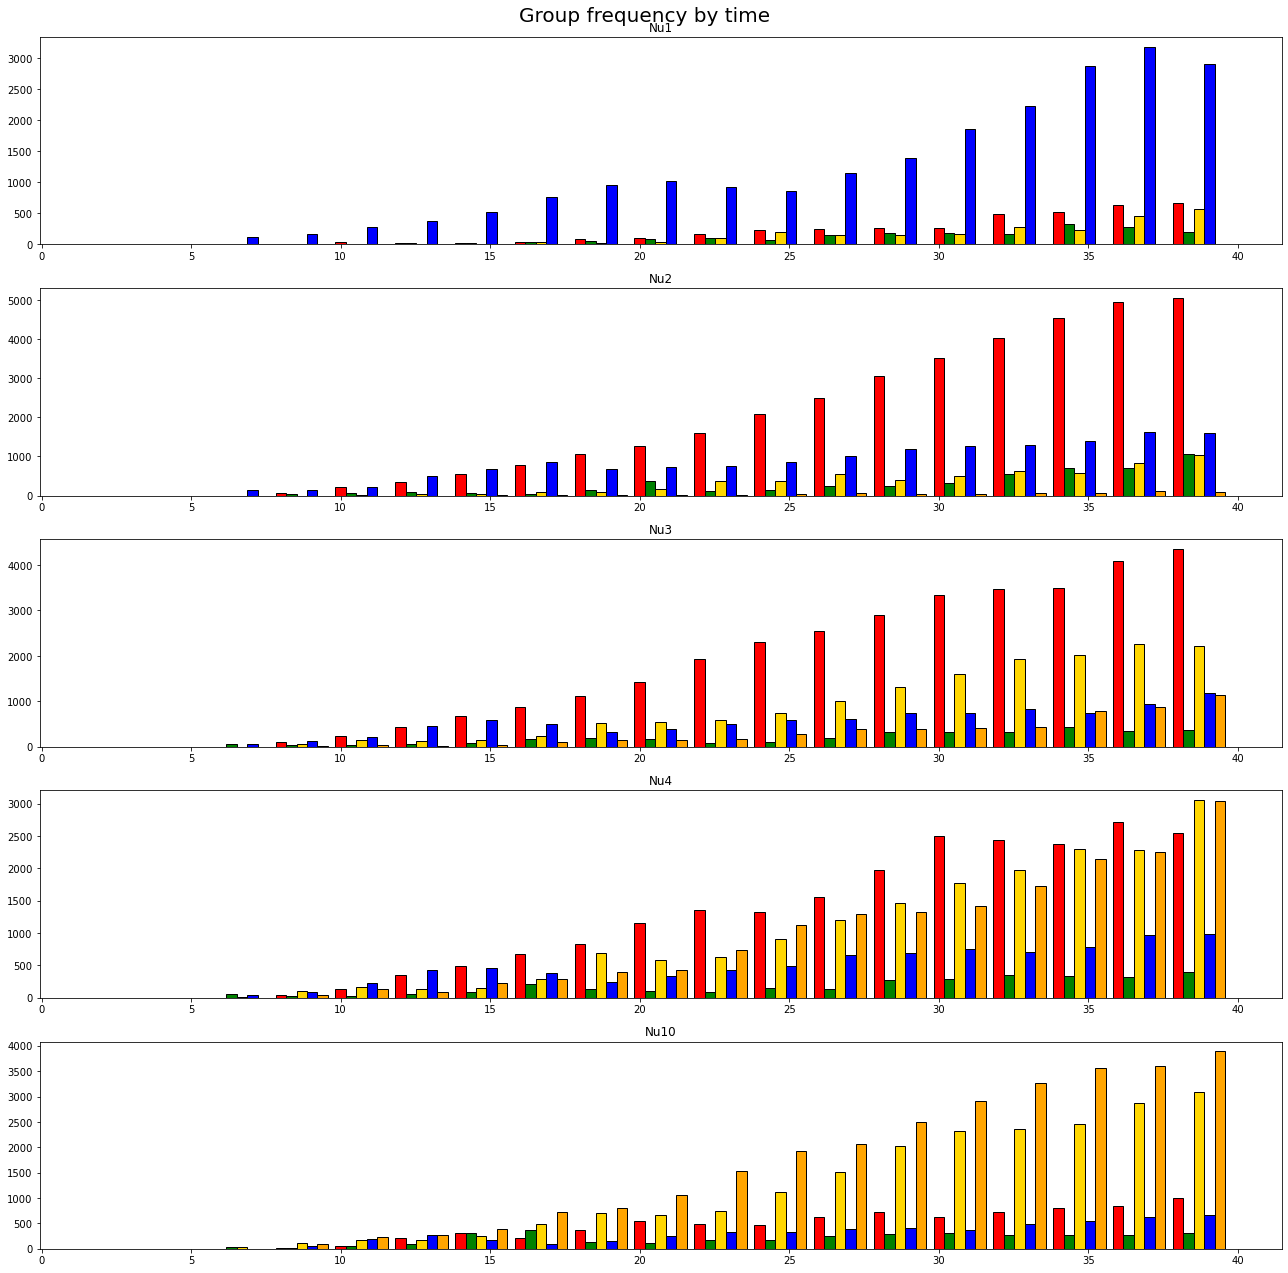

In [29]:
fig, ax = plt.subplots(5,1,figsize=(18,18))
axf = ax.flatten()
f=0
axf[f].bar(nu1tms,np.array(hist1)[:,1],facecolor='red',width=0.35,edgecolor='k')
axf[f].bar(np.array(nu1tms)+.35,np.array(hist1)[:,2],facecolor='green',width=0.35,edgecolor='k')
axf[f].bar(np.array(nu1tms)+.7,np.array(hist1)[:,3],facecolor='gold',width=0.35,edgecolor='k')
axf[f].bar(np.array(nu1tms)+1.05,np.array(hist1)[:,4],facecolor='blue',width=0.35,edgecolor='k')
axf[f].bar(np.array(nu1tms)+1.4,np.array(hist1)[:,5],facecolor='orange',width=0.35,edgecolor='k')
axf[f].set_title('Nu1')
f=1
axf[f].bar(nu1tms,np.array(hist2)[:,1],facecolor='red',width=0.35,edgecolor='k')
axf[f].bar(np.array(nu1tms)+.35,np.array(hist2)[:,2],facecolor='green',width=0.35,edgecolor='k')
axf[f].bar(np.array(nu1tms)+.7,np.array(hist2)[:,3],facecolor='gold',width=0.35,edgecolor='k')
axf[f].bar(np.array(nu1tms)+1.05,np.array(hist2)[:,4],facecolor='blue',width=0.35,edgecolor='k')
axf[f].bar(np.array(nu1tms)+1.4,np.array(hist2)[:,5],facecolor='orange',width=0.35,edgecolor='k')
axf[f].set_title('Nu2')


f=2
axf[f].bar(nu1tms,np.array(hist3)[:,1],facecolor='red',width=0.35,edgecolor='k')
axf[f].bar(np.array(nu1tms)+.35,np.array(hist3)[:,2],facecolor='green',width=0.35,edgecolor='k')
axf[f].bar(np.array(nu1tms)+.7,np.array(hist3)[:,3],facecolor='gold',width=0.35,edgecolor='k')
axf[f].bar(np.array(nu1tms)+1.05,np.array(hist3)[:,4],facecolor='blue',width=0.35,edgecolor='k')
axf[f].bar(np.array(nu1tms)+1.4,np.array(hist3)[:,5],facecolor='orange',width=0.35,edgecolor='k')
axf[f].set_title('Nu3')


f=3
axf[f].bar(nu1tms,np.array(hist4)[:,1],facecolor='red',width=0.35,edgecolor='k')
axf[f].bar(np.array(nu1tms)+.35,np.array(hist4)[:,2],facecolor='green',width=0.35,edgecolor='k')
axf[f].bar(np.array(nu1tms)+.7,np.array(hist4)[:,3],facecolor='gold',width=0.35,edgecolor='k')
axf[f].bar(np.array(nu1tms)+1.05,np.array(hist4)[:,4],facecolor='blue',width=0.35,edgecolor='k')
axf[f].bar(np.array(nu1tms)+1.4,np.array(hist4)[:,5],facecolor='orange',width=0.35,edgecolor='k')
axf[f].set_title('Nu4')




f=4
axf[f].bar(nu1tms,np.array(hist10)[:,1],facecolor='red',width=0.35,edgecolor='k')
axf[f].bar(np.array(nu1tms)+.35,np.array(hist10)[:,2],facecolor='green',width=0.35,edgecolor='k')
axf[f].bar(np.array(nu1tms)+.7,np.array(hist10)[:,3],facecolor='gold',width=0.35,edgecolor='k')
axf[f].bar(np.array(nu1tms)+1.05,np.array(hist10)[:,4],facecolor='blue',width=0.35,edgecolor='k')
axf[f].bar(np.array(nu1tms)+1.4,np.array(hist10)[:,5],facecolor='orange',width=0.35,edgecolor='k')
axf[f].set_title('Nu10')


plt.suptitle("Group frequency by time",fontsize=20)
plt.tight_layout()

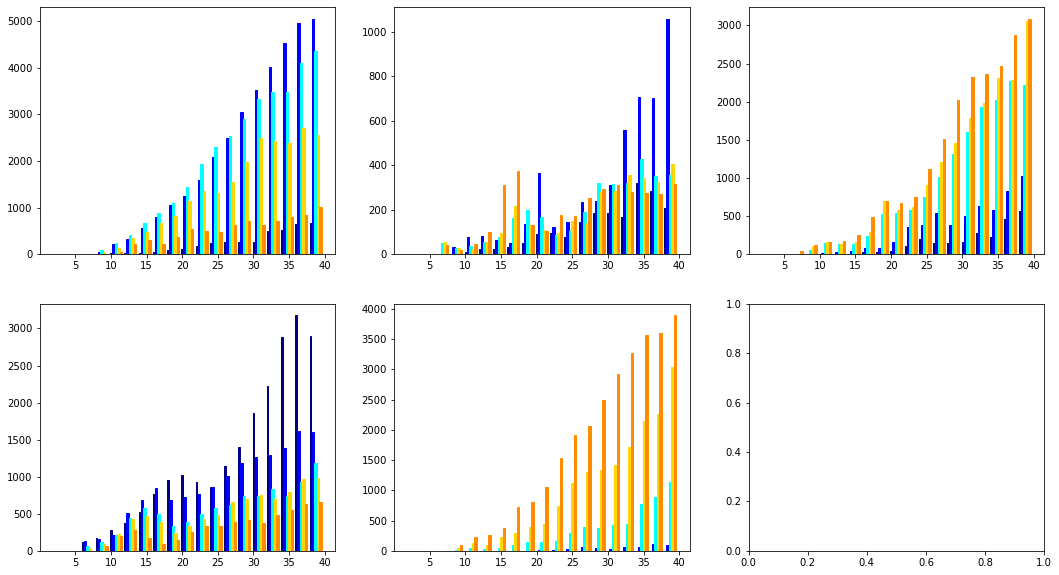

In [30]:
fig, ax = plt.subplots(2,3,figsize=(18,10))
axf = ax.flatten()
f=0
for f in range(5):
    axf[f].bar(nu1tms,np.array(hist1)[:,f+1],facecolor='navy',width=0.2,edgecolor='navy')
    axf[f].bar(np.array(nu2tms)+.35,np.array(hist2)[:,f+1],facecolor='blue',width=0.35,edgecolor='blue')
    axf[f].bar(np.array(nu3tms)+.7,np.array(hist3)[:,f+1],facecolor='cyan',width=0.35,edgecolor='cyan')
    axf[f].bar(np.array(nu4tms)+1.05,np.array(hist4)[:,f+1],facecolor='gold',width=0.35,edgecolor='gold')
    axf[f].bar(np.array(nu10tms)+1.4,np.array(hist10)[:,f+1],facecolor='darkorange',width=0.35,edgecolor='darkorange')







# axf[1].bar(nu10tms,np.array(hist1)[:,2],color='green',width=0.1)
# axf[2].bar(nu10tms,np.array(hist1)[:,3],color='gold',width=0.1)
# axf[3].bar(nu10tms,np.array(hist1)[:,4],color='blue',width=0.1)
# axf[4].bar(nu10tms,np.array(hist1)[:,5],color='orange',width=0.1)
# axf[5].bar(nu10tms,np.array(hist1)[:,6],color='purple',width=0.1)



In [ ]:
#exper = 'MC3E'
exper = 'SUPER_BIN'
exper = 'supercell_nu2'
rfile =ycfg['sims'][exper]['rain_file']
sim_cfg = ycfg['sims'][exper]
mu = 2
#mu = 'bin'

In [ ]:
print(rfile)

In [ ]:
rfile = 'supercell-grant-hires-gnu02-300dx-g1-rain.h5'
#rfile = 'mc3e-2011may20-g3-CLE-rain.h5'
#rfile = 'supercell-grant-hires-hucm-full-300dx-g1-rain.h5'

In [ ]:
alldsd = pickle.load(open('/claudian/bdolan/RAMS/pickles/ramsworld_dsd_baseline3.p','rb'))

In [ ]:
data = xr.open_dataset(f'/claudian/ktucker/RAMS/data/{rfile}',engine='h5netcdf')#,phony_dims='sort')

In [ ]:
tskip =1 
hskip =3

#filtered_rain_dsd_dict = dfunc.format_subsample_dsd_data(data, nu=mu, tskip=sim_cfg['tskip'], hskip=sim_cfg['hskip'],d3=False)
filtered_rain_dsd_dict = dfunc.format_subsample_dsd_data(data, nu=mu, tskip=tskip, hskip=hskip,d3=False)




In [ ]:
blank = np.zeros((filtered_rain_dsd_dict['shp'][0],filtered_rain_dsd_dict['shp'][1],filtered_rain_dsd_dict['shp'][2]))

In [ ]:
ramr =np.ravel(np.zeros_like(blank))
ramr[filtered_rain_dsd_dict['whgd']]=filtered_rain_dsd_dict['rrr']
ramrr = np.reshape(ramr,filtered_rain_dsd_dict['shp'])

ramn =np.ravel(np.zeros_like(blank))
ramn[filtered_rain_dsd_dict['whgd']]=filtered_rain_dsd_dict['nww']
ramnw = np.reshape(ramn,filtered_rain_dsd_dict['shp'])

ramd =np.ravel(np.zeros_like(blank))
ramd[filtered_rain_dsd_dict['whgd']]=filtered_rain_dsd_dict['d00']
ramd0 = np.reshape(ramd,filtered_rain_dsd_dict['shp'])



In [ ]:
blankr=np.ravel(blank)
blankb = blankr[filtered_rain_dsd_dict['whgd']]

In [ ]:
import oa_stats as oa
good_vars = ['nww', 'd00', 'sigm', 'llwc', 'lrr', 'lnt']
labels = [ycfg['vars'][_]['label'] for _ in good_vars]
pc1sea, pc2sea = oa.get_eof_cast(filtered_rain_dsd_dict,alldsd,good_vars)




In [ ]:
rthresh=0.9
ramsgroups1 = dfunc.get_groups(pc1sea,pc2sea,rthresh,rthresh,rthresh,rthresh)
ramsvals1 = dfunc.make_groups(pc1sea,ramsgroups1)




In [ ]:
ramvals2dr =np.ravel(np.zeros_like(blank))*np.nan
ramvals2dr[filtered_rain_dsd_dict['whgd']]=ramsvals1
ramvals2d = np.reshape(ramvals2dr,filtered_rain_dsd_dict['shp'])




In [ ]:
np.shape(ramvals2d)


In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
tm  = tms[6]
c = ax.pcolormesh(ramvals2d[19,:,:],vmin=0,vmax=7,cmap=pcacol)
cb = plt.colorbar(c,ax=ax)
adjust_fhc_colorbar_for_pyart(cb)
plt.title(f"{exper} Surface PC #tstep={tm:03d}")
plt.tight_layout()
plt.savefig(f'/claudian/bdolan/TESTING/{exper}_{tm:03d}_sfc.png',dpi=300,bbox_inches='tight')


In [ ]:

hist, eg = np.histogram(np.ravel(ramvals2d),bins=np.arange(0,8,1))

#plt.hist(np.ravel(ramvals2d),bins=np.arange(0,7,1))

In [ ]:
plt.bar(eg[:-1],hist)

In [ ]:
print(np.nanmax(ramvals2d))